<a href="https://colab.research.google.com/github/boernd/tf-in-practice/blob/master/Exercise_7_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(include_top=False, weights=None, input_shape=(150,150,3))

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

--2020-03-06 19:49:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  31.7MB/s    in 2.6s    

2020-03-06 19:49:59 (31.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i

In [0]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 3, 3, 2048)


In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(units=1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (units=1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]       

In [0]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2020-03-06 20:04:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  52.5MB/s    in 2.7s    

2020-03-06 20:05:02 (52.5 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-03-06 20:05:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/

In [0]:
os.listdir('/tmp/training')
train_horses_dir = '/tmp/training/horses'
train_humans_dir = '/tmp/training/humans'
validation_horses_dir = '/tmp/validation/horses'
validation_humans_dir = '/tmp/validation/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [0]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   rotation_range=90, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   vertical_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='binary')     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         target_size=(150,150),
                                                         batch_size=32,
                                                         class_mode='binary')

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [0]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)

callbacks = myCallback()
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples/32,
                              epochs=100,callbacks=[callbacks],
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples/32)

Epoch 1/100
33/32 [==============================] - 23s 695ms/step - loss: 0.9948 - acc: 0.7001 - val_loss: 1.0651 - val_acc: 0.5938
Epoch 2/100
33/32 [==============================] - 12s 353ms/step - loss: 0.4048 - acc: 0.8403 - val_loss: 0.0576 - val_acc: 0.9883
Epoch 3/100
33/32 [==============================] - 13s 380ms/step - loss: 0.3725 - acc: 0.8647 - val_loss: 0.1184 - val_acc: 0.9570
Epoch 4/100
33/32 [==============================] - 13s 381ms/step - loss: 0.4218 - acc: 0.8500 - val_loss: 1.6582 - val_acc: 0.5312
Epoch 5/100
33/32 [==============================] - 13s 381ms/step - loss: 0.2771 - acc: 0.8822 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 6/100
33/32 [==============================] - 13s 381ms/step - loss: 0.2951 - acc: 0.9007 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 7/100
33/32 [==============================] - 13s 384ms/step - loss: 0.3049 - acc: 0.9085 - val_loss: 1.4939 - val_acc: 0.6289
Epoch 8/100
33/32 [==============================] - 12s 373ms

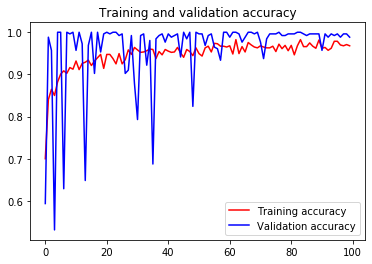

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()